<a href="https://colab.research.google.com/github/elekdra01/Data-Visualization/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hs_merged.csv to hs_merged.csv


In [ ]:

df=pd.read_csv('hs_merged.csv',engine='python',encoding='ISO-8859-1',error_bad_lines=False)


In [ ]:
df.head(2).T 

,0,1
ID,319399851215433729,320817818222358529
Unnamed: 0,2004,5148
Authors,CreatrixKali,quincepoacher
Descriptions,Literary Creatrix for Alternative SpiritMag. C...,"AKA Queenotisblue. Sociology, politics, policy..."
Favorite Count,0,0
Follower Count,169,425
Hashtags,"[{'text': 'MKR', 'indices': [37, 41]}]","[{'text': 'MKR', 'indices': [68, 72]}]"
Locations,Australia,Melbourne
Time Tweeted,2013-04-03 10:43:53,2013-04-07 08:38:23
Tweets,Oh yeah Colin! Smash those girls! :D #MKR,It's insane they keep bringing people back. Wh...


In [ ]:

# Create a new dataframe with two columns
df1 = df[['Class', 'Tweets']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Tweets'])]

# Renaming second column for a simpler name
df1.columns = ['Class', 'Tweets'] 

df1.shape

(16135, 2)

In [ ]:
total = df1['Tweets'].notnull().sum()
round((total/len(df)*100),1)

100.0

In [ ]:
pd.DataFrame(df.Class.unique()).values

array([['sexism'],
       ['none'],
       ['racism']], dtype=object)

In [ ]:
##df2 = df1.sample(10000, random_state=1).copy()
pd.DataFrame(df1.Class.unique())

,0
0,sexism
1,none
2,racism


In [ ]:
# Create a new column 'category_id' with encoded categories 
df1['class_id'] = df1['Class'].factorize()[0]
category_id_df = df1[['Class', 'class_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['class_id', 'Class']].values)

# New dataframe
df1.head()

,Class,Tweets,class_id
0,sexism,Oh yeah Colin! Smash those girls! :D #MKR,0
1,none,It's insane they keep bringing people back. Wh...,1
2,none,@berkeley_eagle #MKR this shit show has more ...,1
3,none,*sigh* oh Colin ? #MKR,1
4,sexism,"RT @brian_day15: I swear, I'm not sexist, but ...",0


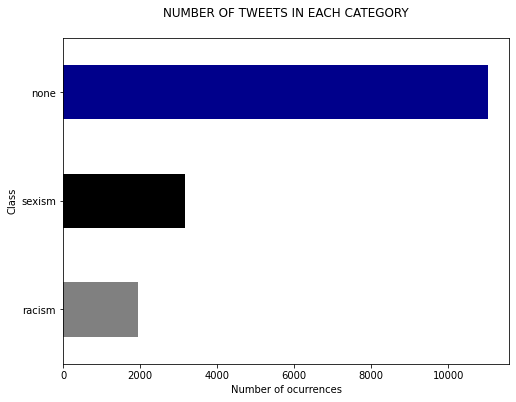

In [ ]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','black','darkblue']
df1.groupby('Class').Tweets.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df1.Tweets).toarray()

labels = df1.class_id

print("Each of the %d tweet is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 16135 tweet is represented by 5795 features (TF-IDF score of unigrams and bigrams)


In [ ]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Class, class_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == class_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Class))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> none:
  * Most Correlated Unigrams are: islam, notsexist, sexist
  * Most Correlated Bigrams are: sexist just, im sexist, sexist women

==> racism:
  * Most Correlated Unigrams are: mohammed, muslims, islam
  * Most Correlated Bigrams are: vandaliser sajid_fairooz, sajid_fairooz israeliregime, 1400 years

==> sexism:
  * Most Correlated Unigrams are: female, notsexist, sexist
  * Most Correlated Bigrams are: sexist just, im sexist, sexist women


In [ ]:
X = df1['Tweets'] # Collection of documents
y = df1['Class'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.749985,0.042216
LogisticRegression,0.769693,0.058485
MultinomialNB,0.744840,0.040650
RandomForestClassifier,0.684103,0.000470


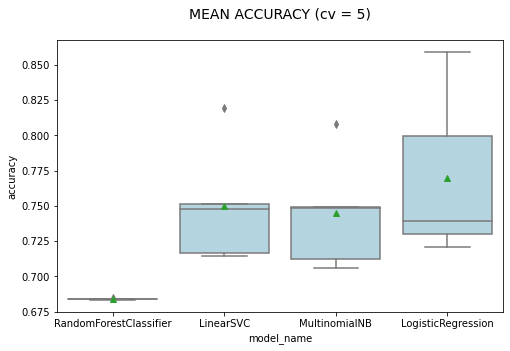

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df1.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df1['Class'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

      sexism       0.81      0.63      0.71       847
        none       0.85      0.92      0.88      2704
      racism       0.78      0.70      0.74       483

    accuracy                           0.83      4034
   macro avg       0.81      0.75      0.78      4034
weighted avg       0.83      0.83      0.83      4034



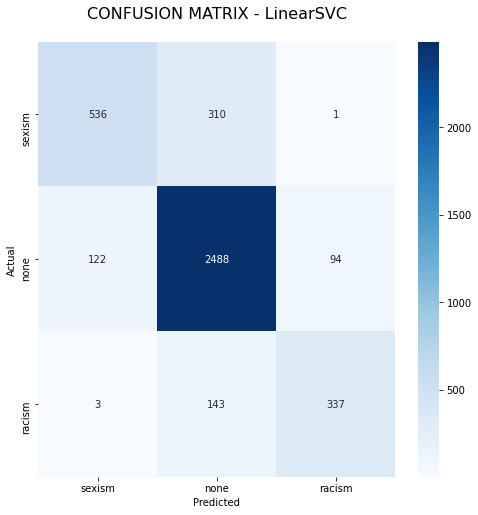

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Class.values, 
            yticklabels=category_id_df.Class.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);